# 🔧 Feature Engineering Completo: Base + Derivadas

**Objetivo:** Crear features base y derivadas para predecir el riesgo de brotes en pacientes con Crohn y CU

**Input:**
- `../data/processed/crohn_filtered.csv` (del notebook 01)
- `../data/processed/cu_filtered.csv` (del notebook 01)

**Output:** Datasets enriquecidos listos para ML:
- `../data/processed/crohn/ml_dataset_enhanced.csv`
- `../data/processed/cu/ml_dataset_enhanced.csv`

**Features:**
- **Base** (13): Síntomas, demografía, historial, temporales
- **Derivadas** (21): Agregaciones, tendencias, interacciones
- **Total**: 34 features

**Autor:** Asier Ortiz García  
**Fecha:** Noviembre 2025

## 📦 Imports y Configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings
import json
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
%matplotlib inline

# Crear directorios
Path('../data/processed/crohn').mkdir(parents=True, exist_ok=True)
Path('../data/processed/cu').mkdir(parents=True, exist_ok=True)
Path('../docs/figures').mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("FEATURE ENGINEERING COMPLETO: Base + Derivadas")
print("=" * 80)

FEATURE ENGINEERING COMPLETO: Base + Derivadas


## PARTE 1: FEATURES BASE

### 🔧 Funciones para Features Base

In [2]:
# Mapeo de síntomas
SYMPTOM_MAPPING = {
    'abdominal_pain': [
        'abdominal pain', 'stomach pain', 'belly pain', 'cramping',
        'abdominal cramps', 'stomach cramps', 'pain'
    ],
    'diarrhea': [
        'diarrhea', 'loose stools', 'watery stools', 'frequent bowel movements',
        'urgent bowel movements', 'urgency'
    ],
    'fatigue': [
        'fatigue', 'tired', 'exhaustion', 'tiredness', 'weakness',
        'lack of energy', 'low energy'
    ],
    'fever': [
        'fever', 'high temperature', 'chills'
    ],
    'blood_in_stool': [
        'blood in stool', 'bloody stool', 'rectal bleeding', 'bleeding'
    ],
    'nausea': [
        'nausea', 'nauseous', 'feeling sick', 'queasiness', 'vomiting'
    ]
}

# Pesos de síntomas
SYMPTOM_WEIGHTS_CROHN = {
    'abdominal_pain': 0.25,
    'diarrhea': 0.25,
    'fatigue': 0.15,
    'blood_in_stool': 0.20,
    'fever': 0.10,
    'nausea': 0.05
}

SYMPTOM_WEIGHTS_UC = {
    'abdominal_pain': 0.20,
    'diarrhea': 0.25,
    'fatigue': 0.15,
    'blood_in_stool': 0.25,
    'fever': 0.10,
    'nausea': 0.05
}

def categorize_symptom(symptom_name):
    if pd.isna(symptom_name):
        return None
    symptom_lower = str(symptom_name).lower()
    for category, keywords in SYMPTOM_MAPPING.items():
        for keyword in keywords:
            if keyword in symptom_lower:
                return category
    return 'other'

def classify_risk(score):
    if score < 0.3:
        return 'low'
    elif score < 0.6:
        return 'medium'
    else:
        return 'high'

print("✓ Funciones base definidas")

✓ Funciones base definidas


In [3]:
def process_base_features(df, ibd_type='crohn', symptom_weights=None):
    """
    Procesar features base de un tipo de IBD específico.
    Retorna: DataFrame con 13 features base
    """
    print(f"\n{'='*80}")
    print(f"PARTE 1: FEATURES BASE - {ibd_type.upper()}")
    print(f"{'='*80}\n")
    
    if symptom_weights is None:
        symptom_weights = SYMPTOM_WEIGHTS_CROHN
    
    # 1. Procesar síntomas
    print("1️⃣ Procesando síntomas...")
    symptoms = df[df['trackable_type'] == 'Symptom'].copy()
    symptoms['symptom_category'] = symptoms['trackable_name'].apply(categorize_symptom)
    symptoms['value_numeric'] = pd.to_numeric(symptoms['trackable_value'], errors='coerce')
    
    symptoms_clean = symptoms[
        (symptoms['value_numeric'] >= 0) & 
        (symptoms['value_numeric'] <= 4) &
        (symptoms['symptom_category'].isin(list(SYMPTOM_MAPPING.keys())))
    ].copy()
    
    symptoms_clean['severity_normalized'] = symptoms_clean['value_numeric'] / 4.0
    print(f"  Síntomas procesados: {len(symptoms_clean):,}")
    
    # 2. Agregar por usuario y fecha
    print("\n2️⃣ Agregando por usuario-fecha...")
    daily_symptoms = symptoms_clean.groupby(
        ['user_id', 'checkin_date', 'symptom_category']
    )['severity_normalized'].max().reset_index()
    
    daily_pivot = daily_symptoms.pivot_table(
        index=['user_id', 'checkin_date'],
        columns='symptom_category',
        values='severity_normalized',
        fill_value=0.0
    ).reset_index()
    
    # 3. Calcular severity score
    print("\n3️⃣ Calculando severity score...")
    symptom_cols = [col for col in daily_pivot.columns if col in SYMPTOM_MAPPING.keys()]
    daily_pivot['severity_score'] = 0.0
    
    for symptom in symptom_cols:
        weight = symptom_weights.get(symptom, 0.1)
        daily_pivot['severity_score'] += daily_pivot[symptom] * weight
    
    daily_pivot['risk_level'] = daily_pivot['severity_score'].apply(classify_risk)
    print(f"  Distribución: {daily_pivot['risk_level'].value_counts().to_dict()}")
    
    # 4. Features demográficos
    print("\n4️⃣ Añadiendo features demográficos...")
    demographics = df[['user_id', 'age', 'sex']].drop_duplicates('user_id')
    daily_pivot = daily_pivot.merge(demographics, on='user_id', how='left')
    
    daily_pivot['age'].fillna(daily_pivot['age'].median(), inplace=True)
    daily_pivot['sex'].fillna('unknown', inplace=True)
    
    gender_map = {'male': 'M', 'female': 'F', 'unknown': 'O', 'other': 'O'}
    daily_pivot['gender'] = daily_pivot['sex'].map(gender_map).fillna('O')
    
    # 5. Disease duration
    print("\n5️⃣ Calculando disease duration...")
    first_checkin = df.groupby('user_id')['checkin_date'].min().reset_index()
    first_checkin.columns = ['user_id', 'first_checkin']
    daily_pivot = daily_pivot.merge(first_checkin, on='user_id', how='left')
    
    daily_pivot['days_since_first_checkin'] = (
        daily_pivot['checkin_date'] - daily_pivot['first_checkin']
    ).dt.days
    daily_pivot['disease_duration_years'] = (daily_pivot['days_since_first_checkin'] / 365.25).fillna(0)
    
    # 6. Previous flares
    print("\n6️⃣ Calculando historial de brotes...")
    daily_pivot = daily_pivot.sort_values(['user_id', 'checkin_date'])
    daily_pivot['is_flare_day'] = (daily_pivot['risk_level'] == 'high').astype(int)
    daily_pivot['cumulative_flare_days'] = daily_pivot.groupby('user_id')['is_flare_day'].cumsum()
    daily_pivot['previous_flares'] = (daily_pivot['cumulative_flare_days'] / 7).astype(int)
    
    def calc_days_since_flare(group):
        group = group.sort_values('checkin_date')
        last_flare_date = None
        days_since = []
        
        for idx, row in group.iterrows():
            if last_flare_date is None:
                days_since.append(365)
            else:
                days = (row['checkin_date'] - last_flare_date).days
                days_since.append(days)
            
            if row['risk_level'] == 'high':
                last_flare_date = row['checkin_date']
        
        group['last_flare_days_ago'] = days_since
        return group
    
    daily_pivot = daily_pivot.groupby('user_id', group_keys=False).apply(calc_days_since_flare)
    
    # 7. Features temporales
    print("\n7️⃣ Añadiendo features temporales...")
    daily_pivot['month'] = daily_pivot['checkin_date'].dt.month
    daily_pivot['day_of_week'] = daily_pivot['checkin_date'].dt.dayofweek
    
    print(f"\n✅ Features base completadas: {len(daily_pivot):,} registros")
    return daily_pivot

print("✓ Función de features base definida")

✓ Función de features base definida


## PARTE 2: FEATURES DERIVADAS

### 🚀 Funciones para Features Derivadas

In [4]:
def create_symptom_aggregations(df, ibd_type='crohn'):
    """Crea features agregadas de síntomas (SIN DATA LEAKAGE)."""
    df = df.copy()
    
    # ⚠️ ELIMINADO: total_symptom_score, gi_score, systemic_score
    # Razón: Calculan el target directamente (data leakage)
    
    # Red flag score (combinación de síntomas de alarma)
    df['red_flag_score'] = (
        (df['blood_in_stool'] == 1.0).astype(int) * 3 +
        (df['fever'] == 1.0).astype(int) * 2 +
        (df['abdominal_pain'] >= 0.7).astype(int) * 1
    )
    
    # Symptom count (número de síntomas activos)
    df['symptom_count'] = (
        (df['abdominal_pain'] > 0.2).astype(int) +
        (df['diarrhea'] > 0.2).astype(int) +
        (df['fatigue'] > 0.2).astype(int) +
        (df['nausea'] > 0.2).astype(int) +
        (df['blood_in_stool'] > 0).astype(int) +
        (df['fever'] > 0).astype(int)
    )
    
    return df

def create_temporal_features(df, window_days=7):
    """Crea features temporales basadas en tendencias (SIN DATA LEAKAGE)."""
    df = df.copy()
    df = df.sort_values(['user_id', 'checkin_date'])
    
    # Tendencias individuales de síntomas (OK - no dependen del target)
    df['pain_trend_7d'] = df.groupby('user_id')['abdominal_pain'].transform(
        lambda x: x.rolling(window_days, min_periods=1).mean()
    )
    df['diarrhea_trend_7d'] = df.groupby('user_id')['diarrhea'].transform(
        lambda x: x.rolling(window_days, min_periods=1).mean()
    )
    df['fatigue_trend_7d'] = df.groupby('user_id')['fatigue'].transform(
        lambda x: x.rolling(window_days, min_periods=1).mean()
    )
    
    # ⚠️ ELIMINADO: symptom_volatility_7d, symptom_change_rate, is_bad_day, days_since_low_symptoms
    # Razón: Dependen de total_symptom_score (que tiene data leakage)
    
    return df

def create_history_features(df):
    """Crea features derivadas del historial."""
    df = df.copy()
    df['flare_frequency'] = df['previous_flares'] / df['disease_duration_years'].clip(lower=1)
    df['recency_score'] = 1 / (1 + df['last_flare_days_ago'] / 30)
    df['disease_burden'] = df['disease_duration_years'] * 0.3 + df['previous_flares'] * 0.7
    df['young_longduration'] = ((df['age'] < 30) & (df['disease_duration_years'] > 5)).astype(int)
    return df

def create_interaction_features(df):
    """Crea features de interacción (SIN DATA LEAKAGE)."""
    df = df.copy()
    
    # Interacciones de síntomas (OK - no dependen del target)
    df['pain_diarrhea_combo'] = df['abdominal_pain'] * df['diarrhea']
    df['blood_and_pain'] = ((df['blood_in_stool'] == 1.0) & (df['abdominal_pain'] >= 0.6)).astype(int)
    
    # ⚠️ ELIMINADO: vulnerable_state, symptom_severity_category, gi_dominant
    # Razón: Dependen de features con data leakage
    
    return df

print("✓ Funciones derivadas definidas")

✓ Funciones derivadas definidas


In [5]:
def create_all_derived_features(df, ibd_type='crohn'):
    """Aplica todas las transformaciones de features derivadas."""
    print(f"\n{'='*80}")
    print(f"PARTE 2: FEATURES DERIVADAS - {ibd_type.upper()}")
    print(f"{'='*80}\n")
    
    print("  1️⃣ Agregaciones de síntomas...")
    df = create_symptom_aggregations(df, ibd_type)
    
    print("  2️⃣ Features temporales...")
    df = create_temporal_features(df)
    
    print("  3️⃣ Features de historial...")
    df = create_history_features(df)
    
    print("  4️⃣ Features de interacción...")
    df = create_interaction_features(df)
    
    print(f"\n✅ Features derivadas completadas: {len(df.columns)} columnas totales")
    return df

print("✓ Función principal de features derivadas definida")

✓ Función principal de features derivadas definida


## 🔄 Procesamiento Completo: Crohn

In [6]:
print("\n" + "="*80)
print("PROCESAMIENTO COMPLETO: CROHN")
print("="*80)

# Cargar datos
df_crohn = pd.read_csv('../data/processed/crohn_filtered.csv')
df_crohn['checkin_date'] = pd.to_datetime(df_crohn['checkin_date'])

print(f"\n✓ Cargado: {len(df_crohn):,} registros, {df_crohn['user_id'].nunique():,} usuarios")

# Parte 1: Features base
df_crohn_base = process_base_features(df_crohn, ibd_type='crohn', symptom_weights=SYMPTOM_WEIGHTS_CROHN)

# Parte 2: Features derivadas
df_crohn_enhanced = create_all_derived_features(df_crohn_base, ibd_type='crohn')

# Guardar
print("\n💾 Guardando datasets...")
df_crohn_enhanced.to_csv('../data/processed/crohn/ml_dataset_enhanced.csv', index=False)
print(f"✅ Guardado: ../data/processed/crohn/ml_dataset_enhanced.csv ({len(df_crohn_enhanced):,} × {len(df_crohn_enhanced.columns)})")


PROCESAMIENTO COMPLETO: CROHN



✓ Cargado: 183,304 registros, 1,075 usuarios

PARTE 1: FEATURES BASE - CROHN

1️⃣ Procesando síntomas...
  Síntomas procesados: 33,209

2️⃣ Agregando por usuario-fecha...



3️⃣ Calculando severity score...
  Distribución: {'low': 5732, 'medium': 1757, 'high': 129}

4️⃣ Añadiendo features demográficos...

5️⃣ Calculando disease duration...

6️⃣ Calculando historial de brotes...



7️⃣ Añadiendo features temporales...

✅ Features base completadas: 7,618 registros

PARTE 2: FEATURES DERIVADAS - CROHN

  1️⃣ Agregaciones de síntomas...
  2️⃣ Features temporales...


  3️⃣ Features de historial...
  4️⃣ Features de interacción...

✅ Features derivadas completadas: 33 columnas totales

💾 Guardando datasets...
✅ Guardado: ../data/processed/crohn/ml_dataset_enhanced.csv (7,618 × 33)


## 🔄 Procesamiento Completo: Colitis Ulcerosa

In [7]:
print("\n" + "="*80)
print("PROCESAMIENTO COMPLETO: CU")
print("="*80)

# Cargar datos
df_cu = pd.read_csv('../data/processed/cu_filtered.csv')
df_cu['checkin_date'] = pd.to_datetime(df_cu['checkin_date'])

print(f"\n✓ Cargado: {len(df_cu):,} registros, {df_cu['user_id'].nunique():,} usuarios")

# Parte 1: Features base
df_cu_base = process_base_features(df_cu, ibd_type='cu', symptom_weights=SYMPTOM_WEIGHTS_UC)

# Parte 2: Features derivadas
df_cu_enhanced = create_all_derived_features(df_cu_base, ibd_type='cu')

# Guardar
print("\n💾 Guardando datasets...")
df_cu_enhanced.to_csv('../data/processed/cu/ml_dataset_enhanced.csv', index=False)
print(f"✅ Guardado: ../data/processed/cu/ml_dataset_enhanced.csv ({len(df_cu_enhanced):,} × {len(df_cu_enhanced.columns)})")


PROCESAMIENTO COMPLETO: CU



✓ Cargado: 171,509 registros, 708 usuarios

PARTE 1: FEATURES BASE - CU

1️⃣ Procesando síntomas...
  Síntomas procesados: 28,438

2️⃣ Agregando por usuario-fecha...

3️⃣ Calculando severity score...
  Distribución: {'low': 5676, 'medium': 1114, 'high': 70}

4️⃣ Añadiendo features demográficos...

5️⃣ Calculando disease duration...

6️⃣ Calculando historial de brotes...



7️⃣ Añadiendo features temporales...

✅ Features base completadas: 6,860 registros

PARTE 2: FEATURES DERIVADAS - CU

  1️⃣ Agregaciones de síntomas...
  2️⃣ Features temporales...


  3️⃣ Features de historial...
  4️⃣ Features de interacción...

✅ Features derivadas completadas: 33 columnas totales

💾 Guardando datasets...
✅ Guardado: ../data/processed/cu/ml_dataset_enhanced.csv (6,860 × 33)


## 📊 Análisis de Correlaciones

In [8]:
# Seleccionar features derivadas para análisis (solo las que NO tienen data leakage)
derived_features = [
    'red_flag_score', 'symptom_count',
    'pain_trend_7d', 'diarrhea_trend_7d', 'fatigue_trend_7d',
    'flare_frequency', 'recency_score', 'disease_burden',
    'pain_diarrhea_combo'
]

# Convertir risk_level a numérico
risk_map = {'low': 0, 'medium': 1, 'high': 2}
df_crohn_enhanced['risk_numeric'] = df_crohn_enhanced['risk_level'].map(risk_map)

correlations = df_crohn_enhanced[derived_features + ['risk_numeric']].corr()['risk_numeric'].drop('risk_numeric').sort_values(ascending=False)

print("\n🔍 Correlación de Features Derivadas con Risk Level (Crohn):")
print("="*60)
for feat, corr in correlations.items():
    print(f"  {feat:30s}: {corr:+.3f}")
    
print("\n⚠️  NOTA: Features con data leakage fueron eliminadas")
print("  Antes: 21 features derivadas | Ahora: 11 features derivadas")


🔍 Correlación de Features Derivadas con Risk Level (Crohn):
  pain_diarrhea_combo           : +0.696
  symptom_count                 : +0.653
  diarrhea_trend_7d             : +0.548
  red_flag_score                : +0.547
  fatigue_trend_7d              : +0.542
  pain_trend_7d                 : +0.518
  recency_score                 : +0.417
  flare_frequency               : +0.315
  disease_burden                : +0.248

⚠️  NOTA: Features con data leakage fueron eliminadas
  Antes: 21 features derivadas | Ahora: 11 features derivadas


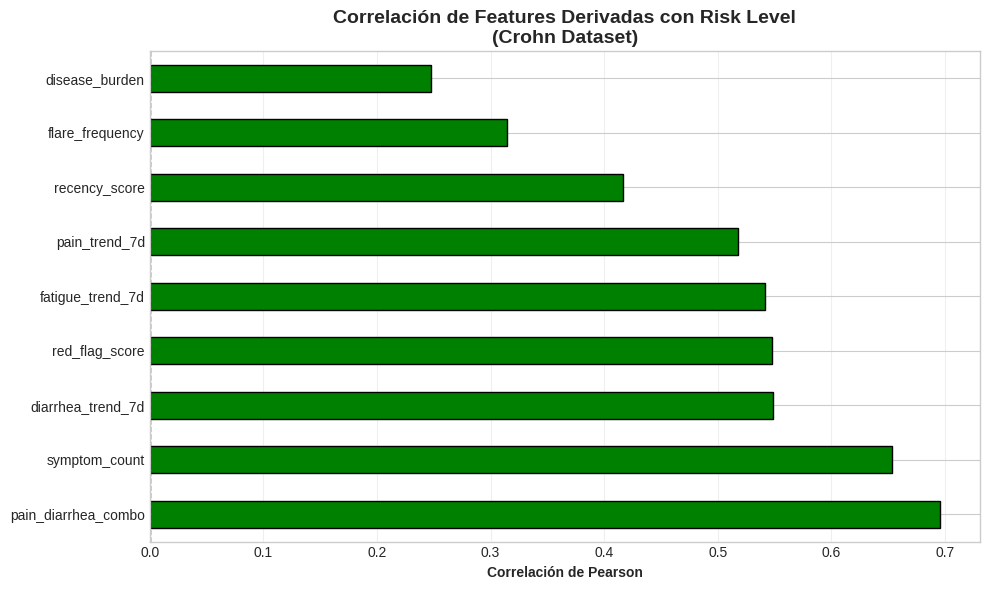


💾 Figura guardada: ../docs/figures/derived_features_correlation.png


In [9]:
# Visualización
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red' if x < 0 else 'green' for x in correlations.values]
correlations.plot(kind='barh', ax=ax, color=colors, edgecolor='black')

ax.set_title('Correlación de Features Derivadas con Risk Level\n(Crohn Dataset)', 
             fontweight='bold', fontsize=14)
ax.set_xlabel('Correlación de Pearson', fontweight='bold')
ax.set_ylabel('')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../docs/figures/derived_features_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Figura guardada: ../docs/figures/derived_features_correlation.png")

## 📊 Visualización Comparativa

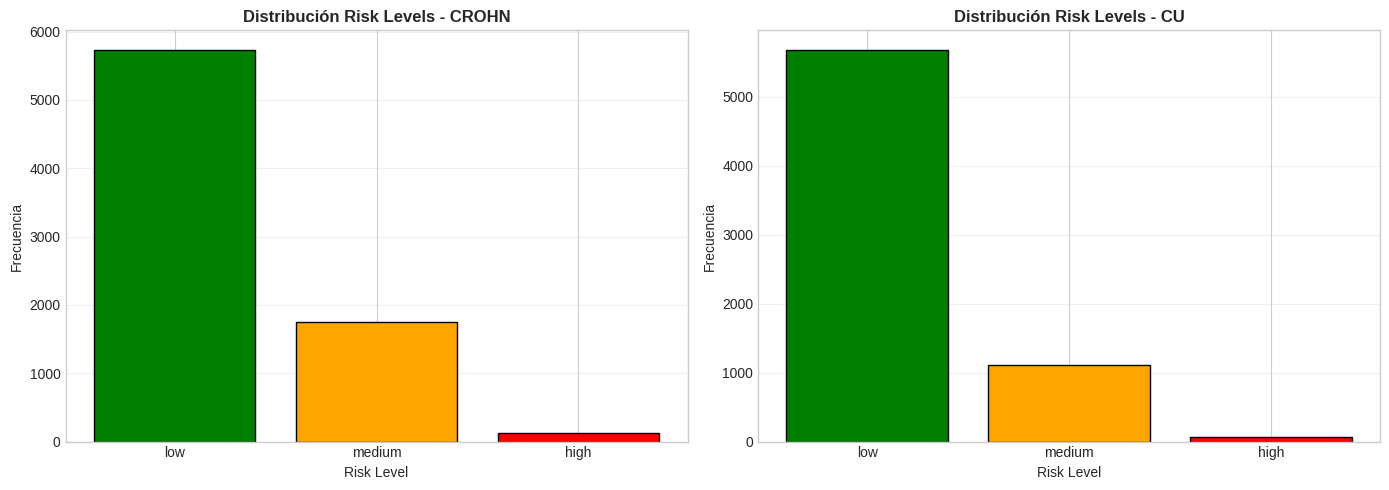

💾 Figura guardada: ../docs/figures/risk_distribution_crohn_vs_cu.png


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Crohn
crohn_counts = df_crohn_enhanced['risk_level'].value_counts()
colors_dict = {'low': 'green', 'medium': 'orange', 'high': 'red'}
axes[0].bar(crohn_counts.index, crohn_counts.values,
           color=[colors_dict.get(x, 'gray') for x in crohn_counts.index],
           edgecolor='black')
axes[0].set_title('Distribución Risk Levels - CROHN', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Risk Level')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True, alpha=0.3, axis='y')

# CU
cu_counts = df_cu_enhanced['risk_level'].value_counts()
axes[1].bar(cu_counts.index, cu_counts.values,
           color=[colors_dict.get(x, 'gray') for x in cu_counts.index],
           edgecolor='black')
axes[1].set_title('Distribución Risk Levels - CU', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Risk Level')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../docs/figures/risk_distribution_crohn_vs_cu.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Figura guardada: ../docs/figures/risk_distribution_crohn_vs_cu.png")

## ✅ Resumen Final

In [11]:
# Definir lista de features para metadata
symptom_features = ['abdominal_pain', 'diarrhea', 'fatigue', 'nausea', 'blood_in_stool', 'fever']
demographic_features = ['age', 'gender']
history_features = ['disease_duration_years', 'previous_flares', 'last_flare_days_ago']
temporal_features = ['month', 'day_of_week']

# ⚠️ FEATURES REDUCIDAS: Eliminadas 10 features con data leakage
# Antes: 21 features derivadas | Ahora: 11 features derivadas
derived_features_list = [
    'red_flag_score', 'symptom_count',
    'pain_trend_7d', 'diarrhea_trend_7d', 'fatigue_trend_7d',
    'flare_frequency', 'recency_score', 'disease_burden', 'young_longduration',
    'pain_diarrhea_combo', 'blood_and_pain'
]

# Metadata
metadata = {
    "base_features": {
        "symptom_features": symptom_features,
        "demographic_features": demographic_features,
        "history_features": history_features,
        "temporal_features": temporal_features
    },
    "derived_features": derived_features_list,
    "derived_features_removed": [
        "total_symptom_score", "gi_score", "systemic_score", "symptom_severity_category",
        "symptom_volatility_7d", "symptom_change_rate", "is_bad_day", "days_since_low_symptoms",
        "vulnerable_state", "gi_dominant"
    ],
    "n_base_features": len(symptom_features + demographic_features + history_features + temporal_features),
    "n_derived_features": len(derived_features_list),
    "n_total_features": len(symptom_features + demographic_features + history_features + temporal_features + derived_features_list),
    "crohn_records": len(df_crohn_enhanced),
    "crohn_users": int(df_crohn_enhanced['user_id'].nunique()),
    "cu_records": len(df_cu_enhanced),
    "cu_users": int(df_cu_enhanced['user_id'].nunique())
}

# Guardar metadata
with open('../data/processed/derived_features_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)

print(f"\n✅ Features Totales: {metadata['n_total_features']}")
print(f"  - Base: {metadata['n_base_features']} (síntomas, demografía, historial, temporales)")
print(f"  - Derivadas: {metadata['n_derived_features']} (REDUCIDO desde 21 para eliminar data leakage)")
print(f"  - Eliminadas: {len(metadata['derived_features_removed'])} features con data leakage")

print(f"\n⚠️  Features eliminadas por data leakage:")
for feat in metadata['derived_features_removed']:
    print(f"    - {feat}")

print(f"\n📊 CROHN:")
print(f"  Registros: {metadata['crohn_records']:,}")
print(f"  Usuarios: {metadata['crohn_users']:,}")
print(f"  Distribución: {df_crohn_enhanced['risk_level'].value_counts().to_dict()}")

print(f"\n📊 CU:")
print(f"  Registros: {metadata['cu_records']:,}")
print(f"  Usuarios: {metadata['cu_users']:,}")
print(f"  Distribución: {df_cu_enhanced['risk_level'].value_counts().to_dict()}")

print("\n📂 Archivos generados:")
print("  - ../data/processed/crohn/ml_dataset_enhanced.csv")
print("  - ../data/processed/cu/ml_dataset_enhanced.csv")
print("  - ../data/processed/derived_features_metadata.json")
print("  - ../docs/figures/derived_features_correlation.png")
print("  - ../docs/figures/risk_distribution_crohn_vs_cu.png")

print("\n" + "="*80)
print("✅ FEATURE ENGINEERING COMPLETADO (SIN DATA LEAKAGE)")
print("="*80)
print("\nPróximo paso: Notebook 03 - Entrenar modelos con features limpias")


RESUMEN FINAL

✅ Features Totales: 24
  - Base: 13 (síntomas, demografía, historial, temporales)
  - Derivadas: 11 (REDUCIDO desde 21 para eliminar data leakage)
  - Eliminadas: 10 features con data leakage

⚠️  Features eliminadas por data leakage:
    - total_symptom_score
    - gi_score
    - systemic_score
    - symptom_severity_category
    - symptom_volatility_7d
    - symptom_change_rate
    - is_bad_day
    - days_since_low_symptoms
    - vulnerable_state
    - gi_dominant

📊 CROHN:
  Registros: 7,618
  Usuarios: 897
  Distribución: {'low': 5732, 'medium': 1757, 'high': 129}

📊 CU:
  Registros: 6,860
  Usuarios: 589
  Distribución: {'low': 5676, 'medium': 1114, 'high': 70}

📂 Archivos generados:
  - ../data/processed/crohn/ml_dataset_enhanced.csv
  - ../data/processed/cu/ml_dataset_enhanced.csv
  - ../data/processed/derived_features_metadata.json
  - ../docs/figures/derived_features_correlation.png
  - ../docs/figures/risk_distribution_crohn_vs_cu.png

✅ FEATURE ENGINEERING CO